### Notebook to develop threshold for modified NDSI (MNDSI) for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

### Import packages

In [1]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry.polygon import Polygon
import earthpy.spatial as es
import scipy
import matplotlib.pyplot as plt
import matplotlib
import itertools

# base directory
basepath = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
impath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SR-stitched/'
# output folder
outpath = basepath+'imagery/Planet/2021-04-20_2021-08-25/MNDSI'

### Define Area of Interest (AOI)
#### Read in a shapefile with AOI polygon

In [2]:
# Load shapefile
fn = basepath+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
print('Original shapefile CRS:',AOI.crs)

# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(32606)

# print information
print('Reprojected shapefile CRS: ',AOI.crs)
print('Shapefile bounds:',AOI.boundary)

Original shapefile CRS: epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTILINESTRING ((393342.531 6698475.452, 3933...
dtype: geometry


### Load image and shapefiles for tuning threshold: digitized snow line & transects

In [3]:
# image
os.chdir(impath) # change directory
im_name = glob.glob('20210821.tif')
print('Image: ',im_name[0])
print('')

# snowline
sl_fn = basepath+'GIS_data/digitized_snowline_picks/20210821_snowline.shp'
sl = gpd.read_file(sl_fn) # snowline
print('Snowline CRS: ',sl.crs)
# Reproject to imagery CRS if necessary
sl = sl.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',sl.crs)
print('Shapefile bounds:',sl.boundary)
print('')

# transect A
tsA_fn = basepath+'GIS_data/digitized_snowline_picks/transectA.shp'
tsA = gpd.read_file(tsA_fn) # snowline
print('Transect A')
print('-----------')
print('CRS:',tsA.crs)
# Reproject to imagery CRS if necessary
tsA = tsA.to_crs(32606)
# print information
print('Reprojected CRS: ',tsA.crs)
print('Bounds:',tsA.boundary)

# transect B
tsB_fn = basepath+'GIS_data/digitized_snowline_picks/transectB.shp'
tsB = gpd.read_file(tsB_fn) # snowline
print('')
print('Transect B')
print('-----------')
print('CRS:',tsB.crs)
# Reproject to imagery CRS if necessary
tsB = tsB.to_crs(32606)
# print information
print('Reprojected CRS: ',tsB.crs)
print('Bounds:',tsB.boundary)

Image:  20210821.tif

Snowline CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (393148.827 6699387.404, 396547.495...
dtype: geometry

Transect A
-----------
CRS: epsg:4326
Reprojected CRS:  epsg:32606
Bounds: 0    MULTIPOINT (395302.318 6697506.970, 394695.292...
dtype: geometry

Transect B
-----------
CRS: epsg:4326
Reprojected CRS:  epsg:32606
Bounds: 0    MULTIPOINT (395676.063 6699864.600, 395407.264...
dtype: geometry


### Identify snow by adjusting thresholds

In [11]:
# Determine thresholds
thresh_min = 1.5
thresh_max = 5.4

/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo/planet-snow/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)
/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo/planet-snow/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: overflow encountered in ushort_scalars
  n_diff = (b1 - b2) / (b1 + b2)


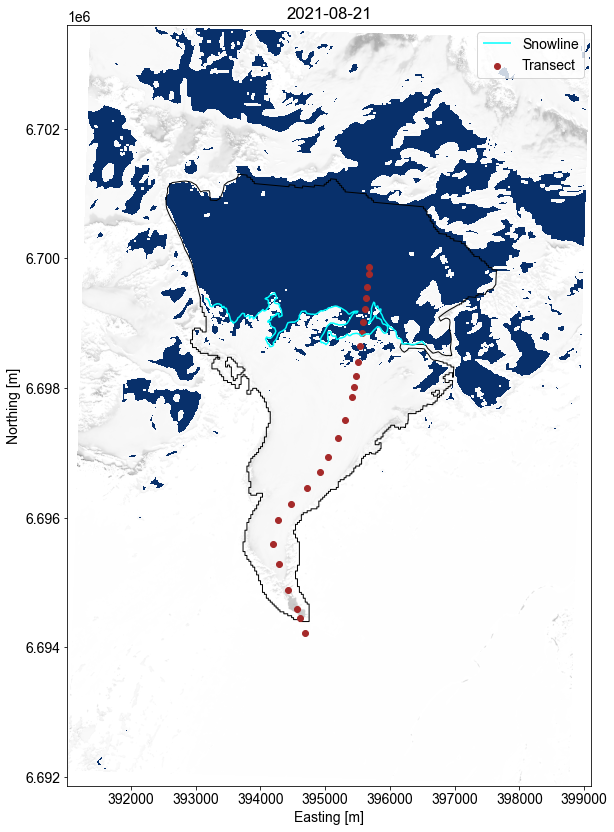

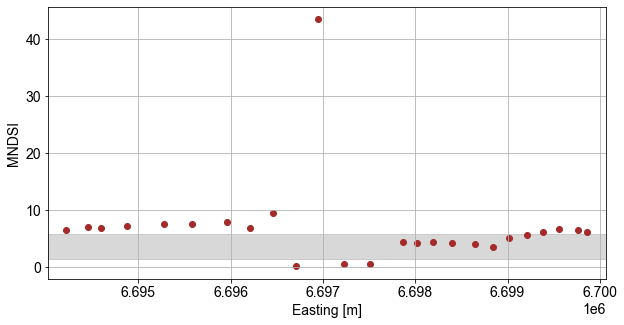

In [12]:
# function to calculate MNDSI
def calculate_mndsi(nir,red):
    mndsi = es.normalized_diff(nir, red)
    return mndsi

# open image
im = rio.open(im_name[0])

# define bands, convert to TOA reflectance
#refl_coeff = 5.12134605626e-05 # from image metadata
blue = im.read(1)#*refl_coeff
green = im.read(2)#*refl_coeff
red = im.read(3)#*refl_coeff
nir = im.read(4)#*refl_coeff
# compute MNDSI
mndsi = calculate_mndsi(nir,red) 

# threshold MNDSI to determine snow cover
snow = np.where((mndsi>thresh_min) & (mndsi<thresh_max),1,np.nan)

### interpolate MNDSI along snowline and transect 
## snowline
# extract points from geometry
sl_pts = [i for i in sl.geometry]
sl_x,sl_y = sl_pts[0].coords.xy
sl_coords = np.dstack((sl_x,sl_y)).tolist()
## transect A
# extract points from geometry
tsA_pts = [i for i in tsA.geometry]
tsA_x,tsA_y = tsA_pts[0].coords.xy
tsA_coords = np.dstack((tsA_x,tsA_y)).tolist()
# sample raster values at coordinates
tsA_rv = [x for x in im.sample(tsA_coords[0])]
# calculate MNDSI at points
tsA_mndsi=[]
for s in tsA_rv:
    tsA_mndsi = tsA_mndsi + [calculate_mndsi(s[3],s[2])]
## transect B
# extract points from geometry
tsB_pts = [i for i in tsB.geometry]
tsB_x,tsB_y = tsB_pts[0].coords.xy
tsB_coords = np.dstack((tsB_x,tsB_y)).tolist()
# sample raster values at coordinates
tsB_rv = [x for x in im.sample(tsB_coords[0])]
# calculate MNDSI at points
tsB_mndsi=[]
for s in tsB_rv:
    tsB_mndsi = tsB_mndsi + [calculate_mndsi(s[3],s[2])]
    
# plot 
fig1, ax1 = plt.subplots(1,1,figsize=(14,14))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# MNDSI, snow, snowline, and transect locations
show(mndsi, transform=im.transform, cmap='Greys', ax=ax1)
show(snow, transform=im.transform, cmap='Blues', clim=(0,1), ax=ax1)
AOI.plot(ax=ax1, facecolor='none', edgecolor='black', label='AOI')
sl.plot(ax=ax1, linestyle='-', color='cyan', label='Snowline')
ax1.scatter(tsA_x, tsA_y, color='brown', label='Transect')
ax1.scatter(tsB_x, tsB_y, color='brown', label='')
ax1.set_title('2021-08-21')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.legend()
# MNDSI values along transect
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))
plt.rcParams.update({'font.size': 14})
ax2.set_xlim(np.min(tsA_y)-200, np.max(tsB_y)+200)
rect=matplotlib.patches.Rectangle((ax2.get_xlim()[0],thresh_min),ax2.get_xlim()[1]-ax2.get_xlim()[0],thresh_max-thresh_min, 
                        fill=True, color="grey", alpha=0.3, label='threshold')
plt.gca().add_patch(rect)
ax2.scatter(tsA_y, np.flip(tsA_mndsi), color='brown', label='Transect')
ax2.scatter(tsB_y, np.flip(tsB_mndsi), color='brown', label='')
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('MNDSI')
ax2.grid()
plt.show()